# Imports

In [1]:
import cudf as pd
import cupy
import dask
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import random
import shap
import seaborn as sns
import tensorflow as tf

from cuml import RandomForestRegressor as CudaRandomForest
from cuml.metrics import mean_absolute_error
from shap.plots import colors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from xgboost import XGBRegressor

SEED = 100


def reset_seed(rnd_seed=SEED):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(rnd_seed)
    np.random.seed(rnd_seed)
    cupy.random.seed(rnd_seed)
    tf.random.set_seed(rnd_seed)


reset_seed()
dask.config.set(scheduler="threads", num_workers=30)


2024-09-09 15:26:57.465668: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 15:26:57.465793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 15:26:57.472500: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 15:26:57.612561: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-09 15:27:11.785417: W tensorflow/compiler/tf2

# Dataset
## Load

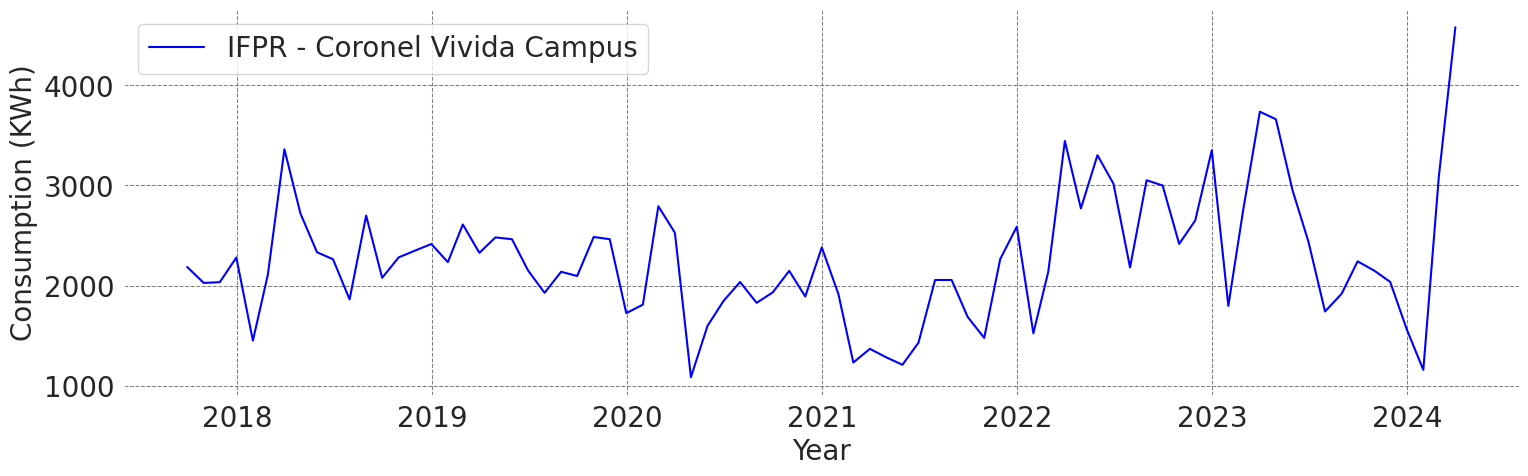

,year,month,consumption,covid
date,,,,
2017-09-30,2017,9,2187,0.0
2017-10-31,2017,10,2028,0.0
2017-11-30,2017,11,2035,0.0
2017-12-31,2017,12,2281,0.0
2018-01-31,2018,1,1452,0.0
...,...,...,...,...
2023-11-30,2023,11,2038,0.0
2023-12-31,2023,12,1565,0.0
2024-01-31,2024,1,1160,0.0


In [2]:
df = pd.read_csv('dataset - Coronel/electricity.csv', sep=";", decimal=",", header=0)
df_climatic = pd.read_csv('dataset - Coronel/climatic.csv', sep=";", decimal=",", header=0)

df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y")
df_climatic["date"] = pd.to_datetime(df_climatic["date"], format="%d/%m/%Y")

df.drop("order", axis=1, inplace=True)
df.set_index("date", inplace=True)
df_climatic.set_index("date", inplace=True)

plt.figure(figsize=(18, 5))
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})
plt.plot(df["consumption"], label="IFPR - Coronel Vivida Campus", color="blue")
plt.xlabel('Year')
plt.ylabel('Consumption (KWh)')

ax = plt.gca()
ax.set_facecolor('white')
plt.grid(True, color='grey', linestyle="--", linewidth=0.75)
plt.legend(facecolor='white')
plt.savefig("results - Coronel 12m/Serie-Coronel.png", bbox_inches='tight')
plt.show()

df


## Autocorrelation

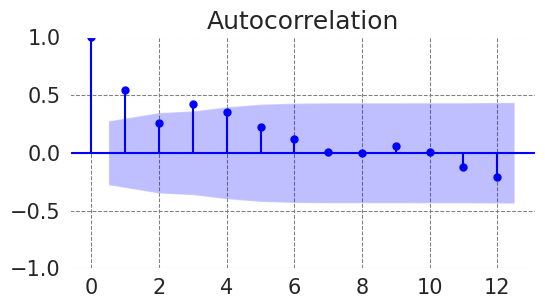

In [14]:
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams.update({'font.size': 15})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["blue"])

fig, ax = plt.subplots(figsize=(6, 3))
ax.set_facecolor('white')
plt.grid(True, color='grey', linestyle="--", linewidth=0.75)

plot_acf(df[:50]["consumption"].to_pandas(), ax=ax, lags=12)
plt.savefig("results - Coronel 12m/CORR-ACF-Coronel.png", bbox_inches='tight')
plt.show()


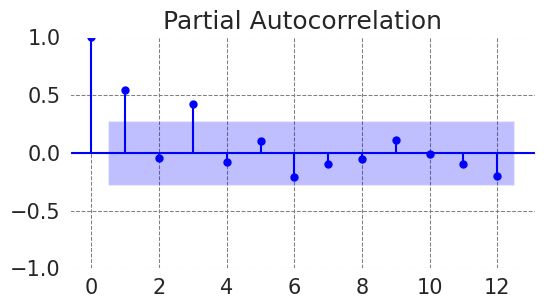

In [15]:
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams.update({'font.size': 15})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["blue"])

fig, ax = plt.subplots(figsize=(6, 3))
ax.set_facecolor('white')
plt.grid(True, color='grey', linestyle="--", linewidth=0.75)

plot_pacf(df[:50]["consumption"].to_pandas(), ax=ax, lags=12)
plt.savefig("results - Coronel 12m/CORR-PACF-Coronel.png", bbox_inches='tight')
plt.show()


## Hypotesis Tests

The hypothesis tests were carried out in the R language, according to the "Hypotesis Tests.R" File.

# Preprocessing
## Missing Values

In [7]:
for index, row in df_climatic[df_climatic.isnull()].to_pandas().iterrows():
    df_mes = df_climatic[df_climatic["month"] == df_climatic.at[index, "month"]]
    for col in row.index:
        if pandas.isnull(df_climatic.at[index, col]):
            df_mes.at[index, col] = df_mes[col].sum() / df_mes[col][df_mes[col].isnull() == False].count()
            df_climatic.at[index, col] = df_mes.at[index, col]


## LAG Creation

In [8]:
for lag_col in ["consumption"]:
    for i in range(1, 12 + 1):
        lag_eletricity = df[lag_col].shift(i)
        df[f'LAG_' + '{:02d}'.format(i)] = lag_eletricity


## Datasets Merge

In [9]:
df = pd.merge(left=df, right=df_climatic, on=["date", "month", "year"], how="left").sort_index()
df

,year,month,consumption,covid,LAG_01,LAG_02,LAG_03,LAG_04,LAG_05,LAG_06,...,maxtemp_abs,maxtemp_mean,maxtemp_mean_abs,mintemp_abs,mintemp_mean,mintemp_mean_abs,windmaxvel_abs,windmaxvel_mean,windmaxvel_mean_abs,Unnamed: 17
date,,,,,,,,,,,,,,,,,,,,,
2017-09-30,2017,9,2187,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2017-10-31,2017,10,2028,0.0,2187,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2017-11-30,2017,11,2035,0.0,2028,2187,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2017-12-31,2017,12,2281,0.0,2035,2028,2187,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2018-01-31,2018,1,1452,0.0,2281,2035,2028,2187,<NA>,<NA>,...,30.7,22.639,30.7,14.9,21.585,14.9,8.0,3.545,85.781,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,2023,11,2038,0.0,2151,2243,1919,1743,2438,2956,...,35.1,22.867,35.1,12.6,22.145,12.6,9.0,4.081,78.239,9.0
2023-12-31,2023,12,1565,0.0,2038,2151,2243,1919,1743,2438,...,34.4,23.694,34.4,13.2,23.206,13.2,7.5,3.698,80.179,7.5
2024-01-31,2024,1,1160,0.0,1565,2038,2151,2243,1919,1743,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


## Dummy Variables Creation

In [10]:
df_meses = pd.get_dummies(df["month"].astype(int), prefix="", prefix_sep="", dtype=int).rename(
    columns={"1": "month_JAN", "2": "month_FEV", "3": "month_MAR", "4": "month_ABR", "5": "month_MAI", "6": "month_JUN",
             "7": "month_JUL", "8": "month_AGO", "9": "month_SET", "10": "month_OUT", "11": "month_NOV",
             "12": "month_DEZ"}
)
df_anos = pd.get_dummies(df["year"].astype(int), prefix="", prefix_sep="", dtype=int).rename(
    columns={"2017": "year_2017", "2018": "year_2018", "2019": "year_2019", "2020": "year_2020", "2021": "year_2021",
             "2022": "year_2022", "2023": "year_2023", "2024": "year_2024"}
)
df = pd.concat([df, df_meses, df_anos], axis=1)
df = df.drop(["month", "year"], axis=1)
df = df.astype("float32").dropna()

df_show = df.to_pandas()
df_show

,consumption,covid,LAG_01,LAG_02,LAG_03,LAG_04,LAG_05,LAG_06,LAG_07,LAG_08,...,month_NOV,month_DEZ,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
date,,,,,,,,,,,,,,,,,,,,,
2018-09-30,2079.0,0.0,2700.0,1863.0,2264.0,2334.0,2721.0,3361.0,2110.0,1452.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-31,2283.0,0.0,2079.0,2700.0,1863.0,2264.0,2334.0,2721.0,3361.0,2110.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-30,2349.0,0.0,2283.0,2079.0,2700.0,1863.0,2264.0,2334.0,2721.0,3361.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31,2416.0,0.0,2349.0,2283.0,2079.0,2700.0,1863.0,2264.0,2334.0,2721.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-31,2235.0,0.0,2416.0,2349.0,2283.0,2079.0,2700.0,1863.0,2264.0,2334.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,1919.0,0.0,1743.0,2438.0,2956.0,3661.0,3736.0,2761.0,1799.0,3351.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2023-09-30,2243.0,0.0,1919.0,1743.0,2438.0,2956.0,3661.0,3736.0,2761.0,1799.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2023-10-31,2151.0,0.0,2243.0,1919.0,1743.0,2438.0,2956.0,3661.0,3736.0,2761.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
df_all = pd.read_csv('dataset - Palmas/elect_merged_selected.csv', sep=";", decimal=".", header=0)
df_all["date"] = pd.to_datetime(df_all["date"], format="%Y-%m-%d")
df_all.set_index("date", inplace=True)

df = df[df_all.columns]

df.to_pandas().to_csv(f"dataset - Coronel/elect_merged_selected.csv", sep=";", decimal=",")
df_all

,consumption,covid,LAG_01,LAG_02,LAG_03,LAG_06,LAG_12,maxtemp_mean_abs,mintemp_abs,windmaxvel_abs,month_MAR,year_2019
date,,,,,,,,,,,,
2018-09-30,"21969,0","0,0","22575,0","17751,0","20841,0","18671,0","22163,0","22,25","3,1","19,6","0,0","0,0"
2018-10-31,"20174,0","0,0","21969,0","22575,0","17751,0","21052,0","19732,0","22,37","7,5","18,0","0,0","0,0"
2018-11-30,"19998,0","0,0","20174,0","21969,0","22575,0","21095,0","20742,0","26,12","11,2","16,6","0,0","0,0"
2018-12-31,"20426,0","0,0","19998,0","20174,0","21969,0","20841,0","18585,0","27,76","6,9","19,1","0,0","0,0"
2019-01-31,"10732,0","0,0","20426,0","19998,0","20174,0","17751,0","10280,0","28,32","16,2","15,8","0,0","1,0"
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,"12207,0","0,0","11286,0","11897,0","21955,0","16964,0","14326,0","24,91","4,3","16,2","0,0","0,0"
2023-12-31,"9588,0","0,0","12207,0","11286,0","11897,0","16655,0","12500,0","27,15","11,8","15,7","0,0","0,0"
2024-01-31,"8226,0","0,0","9588,0","12207,0","11286,0","21165,0","10272,0","26,3","10,6","16,7","0,0","0,0"
